In [523]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.fftpack import dct
import numpy as np
import os
import zipfile
import time

In [604]:
# Define data pre-processing functions 

# Import the mnist dataset 
def import_mnist_data(num_img):
    # Unzip the mnist data
    if not os.path.exists("mnist_dataset/"):
        if os.path.exists("mnist_dataset.zip"):
            with zipfile.ZipFile("mnist_dataset.zip", 'r') as zip_ref:
                zip_ref.extractall("mnist_dataset/")
        else:
            raise FileNotFoundError("mnist_dataset.zip not found.")
    # Load the mnist data
    # Ignore the first column of the data (the label)
    data = np.loadtxt("mnist_dataset/mnist_test.csv", delimiter=",", max_rows=num_img, usecols=range(1,785))
    data = data.reshape(num_img, 784)
    return data


# Sparsify the data by setting all values below a threshold to 0
def sparsify_data(data, threshold):
    sparse_data = np.copy(data)
    for i in range(sparse_data.shape[0]):
        for j in range(sparse_data.shape[1]):
            if sparse_data[i,j] < threshold: 
                sparse_data[i,j] = 0

    return sparse_data

# Generates a random measurement matrix with normalized columns
def make_meas_matrix(rows, cols):
    # Generate a matrix of numbers from the standard normal distribution
    meas_matrix = np.random.randn(rows, cols)
    # Normalize the columns of the matrix
    for i in range(cols):
        meas_matrix[:,i] = meas_matrix[:,i] / np.linalg.norm(meas_matrix[:,i])

    return meas_matrix

# Generate measurements from the data using the measurement matrix
def get_measurements(data, meas_matrix):
    return np.sign(meas_matrix @ data.T)

def plot_algos(data, titles):
    num_images = len(data)
    fig, axs = plt.subplots(1, num_images)
    fig.set_figwidth(14)
    for i in range(0,num_images):
        axs[i].imshow(data[i].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titles[i],fontsize=18)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_meas_matrix(meas_matrix):
    plt.imshow(meas_matrix, cmap='rainbow', vmin=-1, vmax=1)
    plt.title("Measurement Matrix")
    plt.show()

(1, 784)
(1, 784)


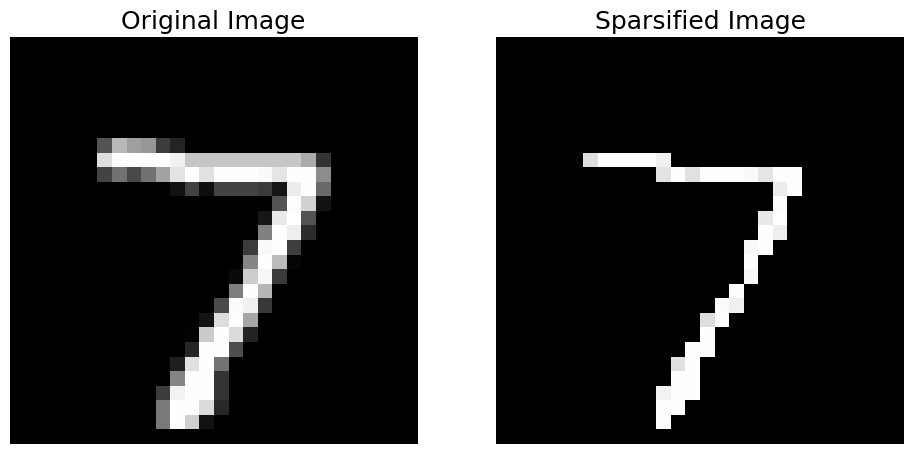

In [603]:
# Testing out data pre-processing functions

data = import_mnist_data(1)
print(data.shape)

sparse_data = sparsify_data(data, 220) # anything below 220 is = zero
print(sparse_data.shape)

plot_algos([data, sparse_data], ["Original Image", "Sparsified Image"])

meas_matrix = make_meas_matrix(200,784)
# plot_meas_matrix(meas_matrix[0:24,0:24])

measurement = get_measurements(sparse_data, meas_matrix)

**Helper Functions**

In [ ]:
def get_k_support(v, k):
    w = np.copy(v)
    support = np.empty(0, dtype=int)
    for i in range(0, k):
        max_index = np.argmax(abs(w))
        support = np.append(support, max_index)
        w[max_index] = 0
    return support

def calculate_normalized_mse(original_data, est_data):
    return np.mean((original_data - est_data)**2) / np.mean(original_data**2)

def calculate_missed_coefficients(original_data, est_data):
    original_data = original_data.reshape((-1, 1))
    est_data = est_data.reshape((-1, 1))
    missed_coefficients = np.count_nonzero((original_data != 0) & (est_data == 0))
    return missed_coefficients

def calculate_misidentified_coefficients(original_data, est_data):
    original_data = original_data.reshape((-1, 1))
    est_data = est_data.reshape((-1, 1))
    mis_ided_coefficients = np.count_nonzero((original_data == 0) & (est_data != 0))
    return mis_ided_coefficients

def calculate_wrong_coefficients(original_data, est_data):
    return (calculate_missed_coefficients(original_data, est_data) + calculate_misidentified_coefficients(original_data, est_data))

def calculate_cosine_similarity(original_data, est_data):
    return (original_data.T @ est_data) / (np.linalg.norm(original_data) * np.linalg.norm(est_data))

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

**One-bit compressed sensing reconstruction algorithms**

***BIHT and RFPI***

In [482]:

# https://link.springer.com/article/10.1007/s11704-017-6132-7?utm_source=chatgpt.com
# https://arxiv.org/pdf/2207.03427
# Binary Iterative Hard Thresholding - assumes we know the sparsity level
# Find a way to dynamically estimate the sparsity
def biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter, known_sparsity=True):

    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []

    step_size = np.sqrt(2*np.pi) / (2*meas_matrix.shape[0]) 

    iter = 0
    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    while iter < max_iter and res_norm > threshold:
        partial_f = meas_matrix.T @ (np.sign(measurement) - np.sign(meas_matrix @ estimate))
        last_estimate = estimate
        estimate = estimate + step_size * partial_f
        
        # Hard thresholding
        support = get_k_support(estimate, sparsity)
        temp = np.zeros((meas_matrix.shape[1], 1))
        temp[support,:] = estimate[support,:]
        estimate = temp

        # If the new residual is smaller than the last residual, increase the sparsity
        if known_sparsity == False:
            if (np.linalg.norm(measurement - np.sign(meas_matrix @ estimate)) < res_norm):
                sparsity += 1

        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        iter += 1
    return estimate, convergence

# https://publications.lib.chalmers.se/records/fulltext/164371/local_164371.pdf
# RFPI - Regularized Fixed Point Iteration
def rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter):

    estimate = np.linalg.pinv(meas_matrix) @ measurement
    estimate = estimate / np.linalg.norm(estimate)
    Y = np.diagflat(measurement)
    iter = 0
    convergence = []

    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    delta = np.linalg.norm(measurement)
    while iter < max_iter and delta > threshold:
        last_estimate = estimate
        s = (Y @ meas_matrix).T @ np.maximum(np.multiply(measurement, meas_matrix @ estimate), np.zeros_like(measurement))
        g = s - (s.T @ estimate) * estimate 
        h = estimate - step_size * g
        estimate = soft_thresholding(h, step_size/lamda)
        estimate /= np.linalg.norm(estimate)
        iter += 1
        
        delta = np.linalg.norm(estimate - last_estimate)
        convergence.append(delta)
    return estimate, convergence
        


**ONE BIT OMP**

In [483]:
def one_bit_omp(meas_matrix, measurement, sparsity, max_iter=None, known_sparsity=True):
    m, n = meas_matrix.shape
    if max_iter is None:
        max_iter = sparsity

    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    support = []
    estimate = np.zeros(n)
    convergence = []

    for it in range(max_iter):
        if len(support) >= sparsity:
            break

        correlations = meas_matrix.T @ residual
        correlations[support] = 0.0  # Mask already selected atoms

        i = np.argmax(np.abs(correlations))
        if i in support:
            continue

        support.append(i)

        # Estimate signal
        A_support = meas_matrix[:, support]
        x_support = np.linalg.pinv(A_support) @ measurement
        estimate = np.zeros(n)
        estimate[support] = x_support

        # If the new residual is smaller than the last residual, increase the sparsity
        if known_sparsity == False:
            if (np.linalg.norm(measurement - np.sign(meas_matrix @ estimate)) < res_norm):
                sparsity += 1

        # Compute residual and convergence metric
        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        if np.all(residual == 0):
            break

    return estimate, convergence


**CVX**

In [486]:
import cvxpy as cp

def convex_l1_sign(meas_matrix, measurement, max_iters=1000):
    """
        convergence: Dummy list since CVXPY does not provide step-wise info.
    """
    m, n = meas_matrix.shape
    x = cp.Variable(n)
    
    # Sign consistency constraints: y_i * (A x)_i >= 1
    constraints = [cp.multiply(measurement, meas_matrix @ x) >= 1]
    objective = cp.Minimize(cp.norm1(x))
    problem = cp.Problem(objective, constraints)
    
    problem.solve(solver=cp.SCS, max_iters=max_iters)
    
    estimate = x.value
    if estimate is None:
        estimate = np.zeros(n)  # fallback 
    
    convergence = []  # placeholder for plotting consistency
    return estimate, convergence


**Helper function test_algo to test our algorithms on multiple images and measurement matrices**

In [588]:
# Loop to test algorithms on multiple images
def test_algo(algo, num_images, sparse_data, measurement_dims, step_size, lamda, sparsity, known_sparsity, threshold, max_iter):

    mses = []
    missed_coeffs = [] 
    misided_coeffs = [] 
    cosine_sims = []
    times = []

    for m in measurement_dims:
        mse_dim = []
        missed_coeff_dim = []
        misided_coeff_dim = []
        cosine_sim_dim = []
        time_dim = []

        for idx in range(0,num_images):
            curr_data = sparse_data[idx,:]
            
            meas_matrix = make_meas_matrix(m,784)
            measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))

            if (known_sparsity == True):
                sparsity = np.count_nonzero(curr_data != 0)
                
            start = time.time()
            if (algo == "rfpi"):
                estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
            elif (algo == "biht"):
                estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter, known_sparsity)
            elif (algo=='one_bit_omp'):
                estimate, convergence=one_bit_omp(meas_matrix, measurement.flatten(), sparsity, max_iter, known_sparsity)
            elif(algo=='msp'):
                estimate, convergence=msp(meas_matrix, measurement.flatten(), sparsity, max_iter)
            elif(algo=='inbuilt_solver'):
                estimate,convergence=convex_l1_sign(meas_matrix, measurement.flatten(), max_iters=1000)
            end = time.time()
            
            # Zero-out negative values - these are erroneous
            estimate[estimate < 0] = 0
            # Renormalize
            estimate = estimate * 255/(np.max(estimate))
            
            missed_coeff_dim.append(calculate_missed_coefficients(curr_data, estimate))
            misided_coeff_dim.append(calculate_misidentified_coefficients(curr_data, estimate))
            mse_dim.append(calculate_normalized_mse(curr_data, estimate))
            cosine_sim_dim.append(calculate_cosine_similarity(curr_data, estimate))
            time_dim.append(end-start)

        mses.append(np.mean(mse_dim))
        missed_coeffs.append(np.mean(missed_coeff_dim))
        misided_coeffs.append(np.mean(misided_coeff_dim))
        cosine_sims.append(np.mean(cosine_sim_dim))
        times.append(np.mean(time_dim))

    return cosine_sims, mses, missed_coeffs, misided_coeffs, curr_data, estimate, convergence, times

def gen_algo_plots(algo_name, algo, data, measurement_dims, step_size, lamda, sparsity, known_sparsity, threshold, max_iter):
    estimates = [data]
    titles = ["Original Image"]
    for m in measurement_dims:        
        meas_matrix = make_meas_matrix(m,784)
        measurement = np.reshape(get_measurements(data, meas_matrix), (m,1))

        if (known_sparsity == True):
            sparsity = np.count_nonzero(data != 0)
            
        if (algo == "rfpi"):
            estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
        elif (algo == "biht"):
            estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter, known_sparsity)

        # Zero-out negative values - these are erroneous
        estimate[estimate < 0] = 0
        # Renormalize
        estimate = estimate * 255/(np.max(estimate))
        estimates.append(estimate)
        titles.append(f"{algo_name}, m = {m}")
    
    plot_algos(estimates, titles)

def plot_sparsities(algo, sparse_data, num_images, m, step_size, lamda, sparsity, known_sparsity, threshold, max_iter):

    n = 784
    meas_matrix = make_meas_matrix(m,n)

    sparsities = []
    cosine_sims = []
    for idx in range(0,num_images):
        curr_data = sparse_data[idx,:]
        
        measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))

        true_sparsity = np.count_nonzero(curr_data != 0)
        if (known_sparsity == True):
            sparsity = true_sparsity
            
        if (algo == "rfpi"):
            estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
        elif (algo == "biht"):
            estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter, known_sparsity)

        # Zero-out negative values - these are erroneous
        estimate[estimate < 0] = 0
        # Renormalize
        estimate = estimate * 255/(np.max(estimate))

        cosine_sims.append(calculate_cosine_similarity(curr_data, estimate))
        sparsities.append(true_sparsity/n)
    
    return cosine_sims, sparsities

            

**TEST AND COMPARE ALGOS**

/Users/josephineking/Desktop/School/Data Compression/EE4740_ImageCompression/img_comp_env/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


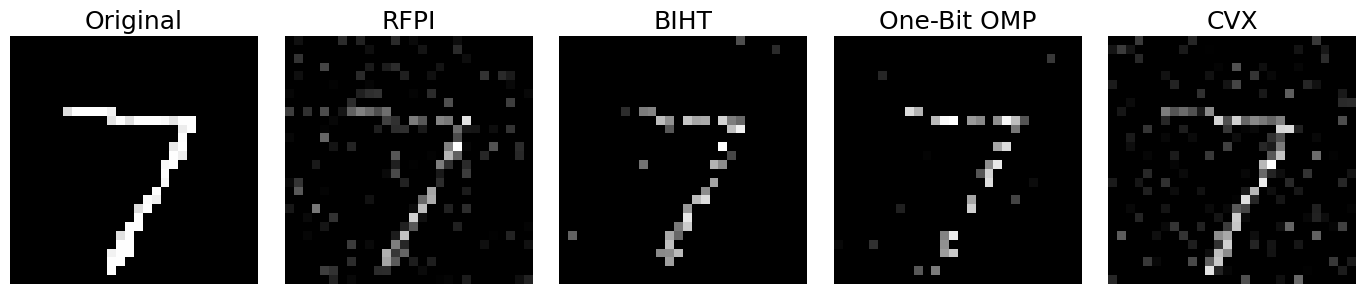

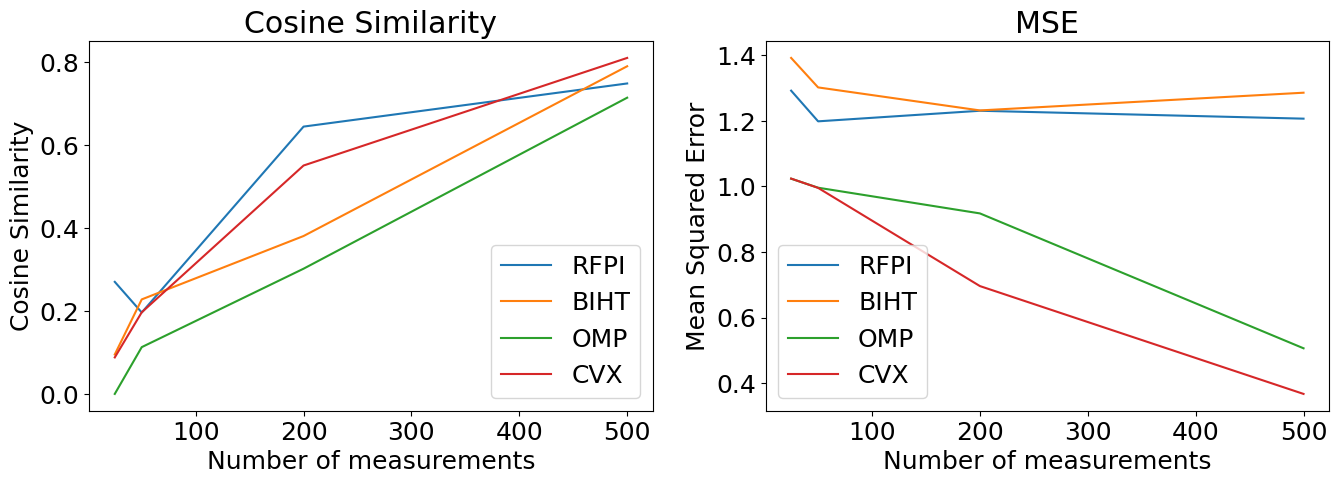

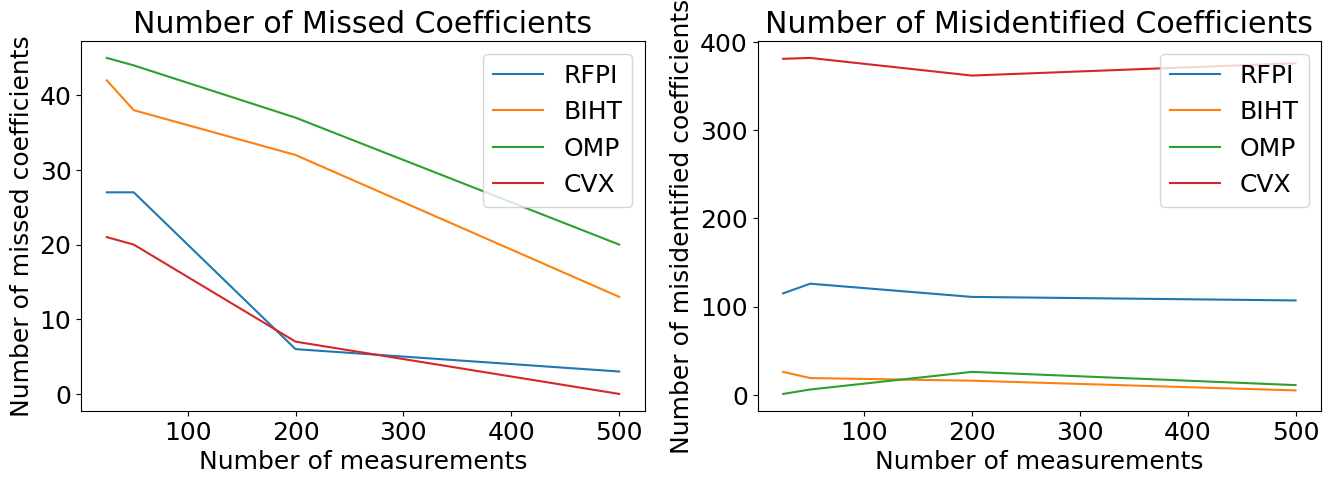

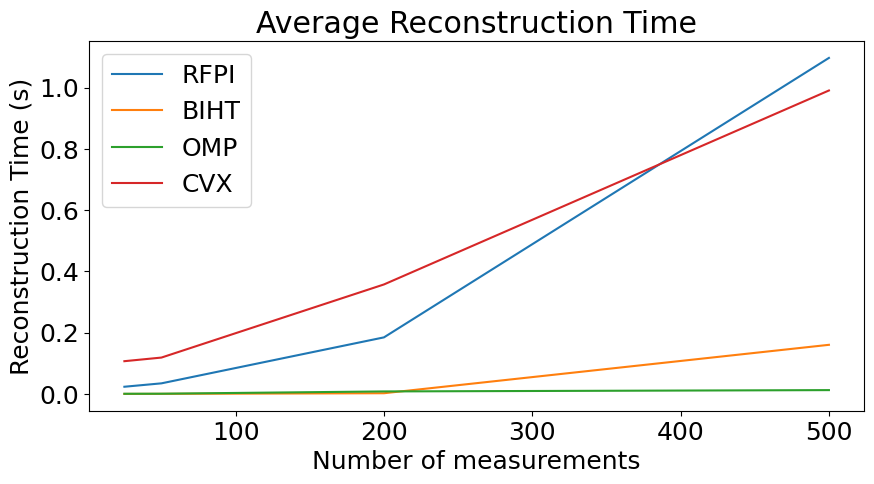

In [ ]:
meas_matrix_dims = [25,50,200,500]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 220)
# Set the randomization seed for consistency
np.random.seed(num_img)

cosine_sim_omp, mses_omp, missed_coeffs_omp, misided_coeffs_omp, curr_data, estimate_omp, convergence_omp, time_omp = test_algo("one_bit_omp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-7, 1000)
cosine_sim_rfpi, mses_rfpi, missed_coeffs_rfpi, misided_coeffs_rfpi, curr_data, estimate_rfpi, convergence_rfpi, time_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.2, 0, False, 1e-4, 1000)
cosine_sim_biht, mses_biht, missed_coeffs_biht, misided_coeffs_biht, curr_data, estimate_biht, convergence_biht, time_biht = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-7, 1000)
cosine_sim_cvx, mses_cvx, missed_coeffs_cvx, misided_coeffs_cvx, curr_data, estimate_cvx, convergence_cvx, time_cvx = test_algo("inbuilt_solver", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)

plot_algos([curr_data, estimate_rfpi, estimate_biht, estimate_omp, estimate_cvx], ["Original", "RFPI", "BIHT", "One-Bit OMP", "CVX"])

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, cosine_sim_rfpi)
axs[0].plot(meas_matrix_dims, cosine_sim_biht)
axs[0].plot(meas_matrix_dims,cosine_sim_omp)
axs[0].plot(meas_matrix_dims,cosine_sim_cvx)
axs[0].set_title("Cosine Similarity")
axs[0].set_xlabel("Number of measurements")
axs[0].set_ylabel("Cosine Similarity")
axs[0].legend(["RFPI", "BIHT","OMP","CVX"])
axs[1].plot(meas_matrix_dims, mses_rfpi)
axs[1].plot(meas_matrix_dims, mses_biht)
axs[1].plot(meas_matrix_dims,mses_omp)
axs[1].plot(meas_matrix_dims,mses_cvx)
axs[1].set_title("MSE")
axs[1].set_xlabel("Number of measurements")
axs[1].set_ylabel("Mean Squared Error")
axs[1].legend(["RFPI", "BIHT","OMP","CVX"])

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, missed_coeffs_rfpi)
axs[0].plot(meas_matrix_dims, missed_coeffs_biht)
axs[0].plot(meas_matrix_dims, missed_coeffs_omp)
axs[0].plot(meas_matrix_dims, missed_coeffs_cvx)
axs[0].set_title("Number of Missed Coefficients")
axs[0].set_xlabel("Number of measurements")
axs[0].set_ylabel("Number of missed coefficients")
axs[0].legend(["RFPI", "BIHT","OMP","CVX"])
axs[1].plot(meas_matrix_dims, misided_coeffs_rfpi)
axs[1].plot(meas_matrix_dims, misided_coeffs_biht)
axs[1].plot(meas_matrix_dims, misided_coeffs_omp)
axs[1].plot(meas_matrix_dims, misided_coeffs_cvx)
axs[1].set_title("Number of Misidentified Coefficients")
axs[1].set_xlabel("Number of measurements")
axs[1].set_ylabel("Number of misidentified coefficients")
axs[1].legend(["RFPI", "BIHT","OMP","CVX"])
plt.show()

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(8)
axs.plot(meas_matrix_dims, time_rfpi)
axs.plot(meas_matrix_dims, time_biht)
axs.plot(meas_matrix_dims, time_omp)
axs.plot(meas_matrix_dims, time_cvx)
axs.set_title("Average Reconstruction Time")
axs.set_xlabel("Number of measurements")
axs.set_ylabel("Reconstruction Time (s)")
axs.legend(["RFPI", "BIHT","OMP","CVX"])



**Test OMP and RFPI** Now that we've chosen these two algorithms, we focus our attention on these two

/var/folders/ql/c3sy06152ddb023_v8jtctww0000gn/T/ipykernel_87899/2117180384.py:42: RuntimeWarning: invalid value encountered in divide
  estimate = estimate * 255/(np.max(estimate))


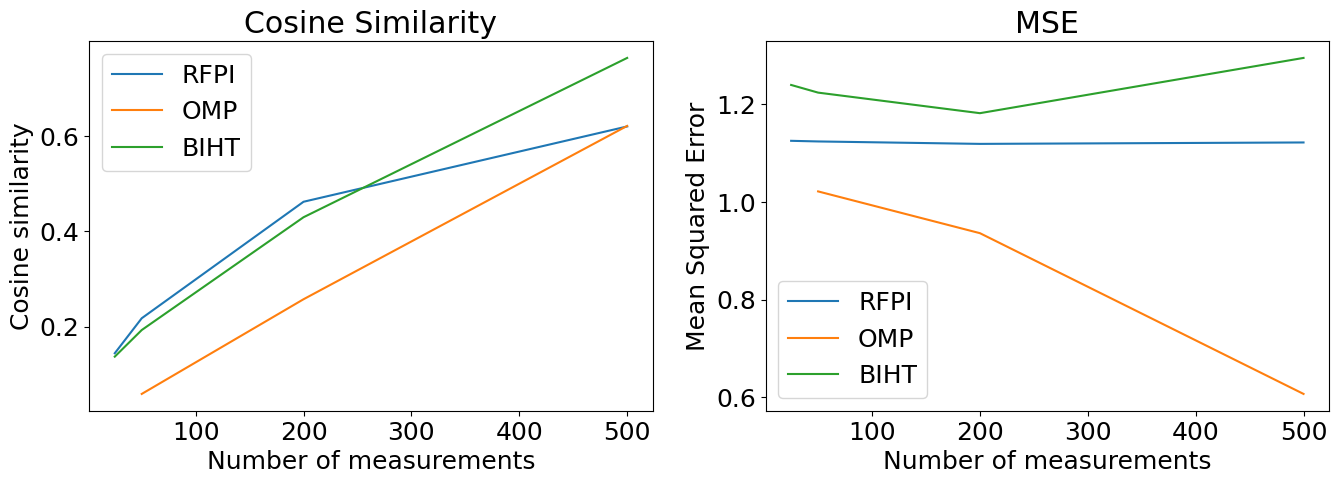

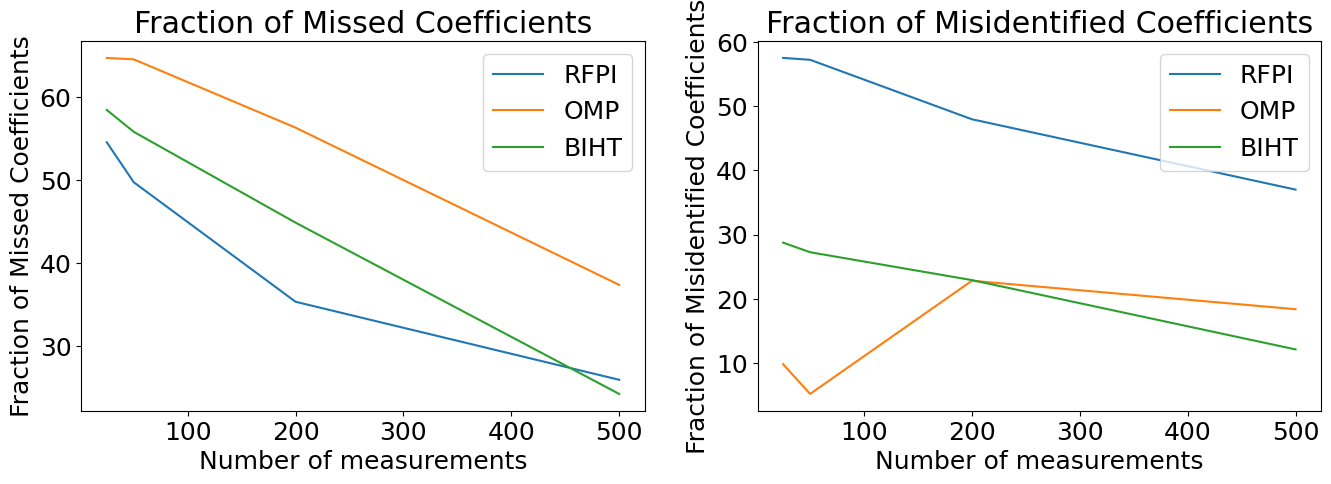

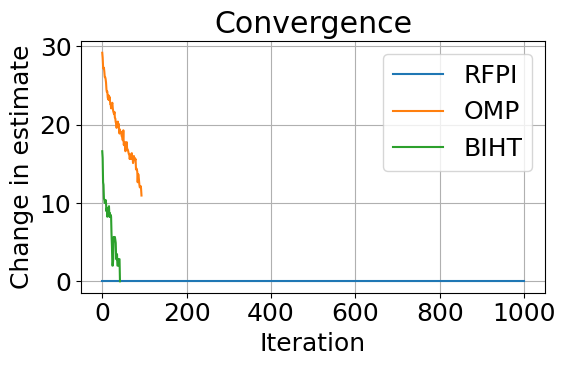

In [ ]:
n = 784
meas_matrix_dims = [25, 50, 200, 500]
meas_matrix_dims_norm = meas_matrix_dims/n
num_img = 100
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 220)

np.random.seed(num_img)

cosine_sim_rfpi, mses_rfpi, missed_coeffs_rfpi, misided_coeffs_rfpi, curr_data, estimate_rfpi, convergence_rfpi, time_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-4, 1, 0, False, 1e-4, 1000)
cosine_sim_biht, mses_biht, missed_coeffs_biht, misided_coeffs_biht, curr_data, estimate_biht, convergence_biht, time_biht = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 0, 1000)
cosine_sim_biht_us, mses_biht_us, missed_coeffs_biht_us, misided_coeffs_biht_us, curr_data, estimate_biht_us, convergence_biht_us, time_biht_us = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 10, False, 0, 1000)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims_norm, cosine_sim_rfpi)
axs[0].plot(meas_matrix_dims_norm,cosine_sim_biht)
axs[0].plot(meas_matrix_dims_norm,cosine_sim_biht_us)
axs[0].set_title("Cosine Similarity")
axs[0].set_xlabel("m/m")
axs[0].set_ylabel("Cosine similarity")
axs[0].legend(["RFPI","BIHT","BIHT (US)"])
axs[1].plot(meas_matrix_dims_norm, mses_rfpi)
axs[1].plot(meas_matrix_dims_norm,mses_biht)
axs[1].plot(meas_matrix_dims_norm,mses_biht_us)
axs[1].set_title("MSE")
axs[1].set_xlabel("m/n")
axs[1].set_ylabel("Mean Squared Error")
axs[1].legend(["RFPI","BIHT","BIHT (US)"])

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims_norm, missed_coeffs_rfpi)
axs[0].plot(meas_matrix_dims_norm, missed_coeffs_biht)
axs[0].plot(meas_matrix_dims_norm, missed_coeffs_biht_us)
axs[0].set_title("Number of Missed Coefficients")
axs[0].set_xlabel("m/n")
axs[0].set_ylabel("Number of Missed Coefficients")
axs[0].legend(["RFPI","BIHT","BIHT (US)"])
axs[1].plot(meas_matrix_dims_norm, misided_coeffs_rfpi)
axs[1].plot(meas_matrix_dims_norm, misided_coeffs_biht)
axs[1].plot(meas_matrix_dims_norm, misided_coeffs_biht_us)
axs[1].set_title("Number of Misidentified Coefficients")
axs[1].set_xlabel("m/n")
axs[1].set_ylabel("Number of Misidentified Coefficients")
axs[1].legend(["RFPI","BIHT","BIHT (US)"])
plt.show()

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(6,4)
axs.plot(meas_matrix_dims, time_rfpi)
axs.plot(meas_matrix_dims, time_biht)
axs.plot(meas_matrix_dims, time_biht_us)
axs.plot(meas_matrix_dims, time_cvx)
axs.set_title("Average Reconstruction Time")
axs.set_xlabel("Number of measurements")
axs.set_ylabel("Reconstruction Time (s)")
axs.legend(["RFPI", "BIHT","BIHT (US)"])


**Estimate the sparsity dynamically**

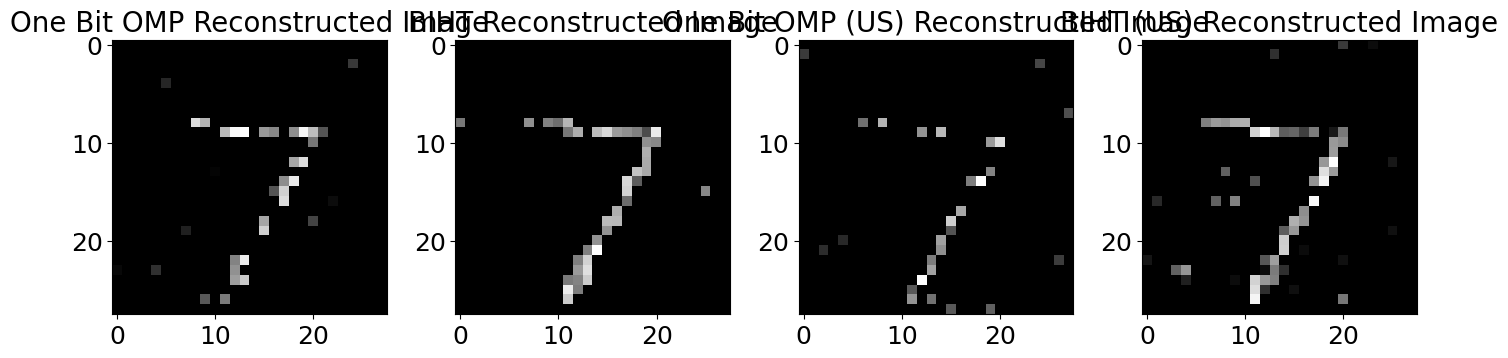

In [562]:
cosine_sim_omp_us, mses_omp_us, missed_coeffs_omp_us, misided_coeffs_omp_us, curr_data, estimate_omp_us, convergence_omp_us, time_omp_us = test_algo("one_bit_omp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 10, False, 1e-7, 1000)
cosine_sim_biht_us, mses_biht_us, missed_coeffs_biht_us, misided_coeffs_biht_us, curr_data, estimate_biht_us, convergence_biht_us, time_biht_us = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 10, False, 1e-7, 1000)


plot_algos([estimate_omp, estimate_biht, estimate_omp_us, estimate_biht_us], ["One Bit OMP Reconstructed Image", "BIHT Reconstructed Image",  "One Bit OMP (US) Reconstructed Image", "BIHT (US) Reconstructed Image"])


**Compare different algorithms for different numbers of measurements**

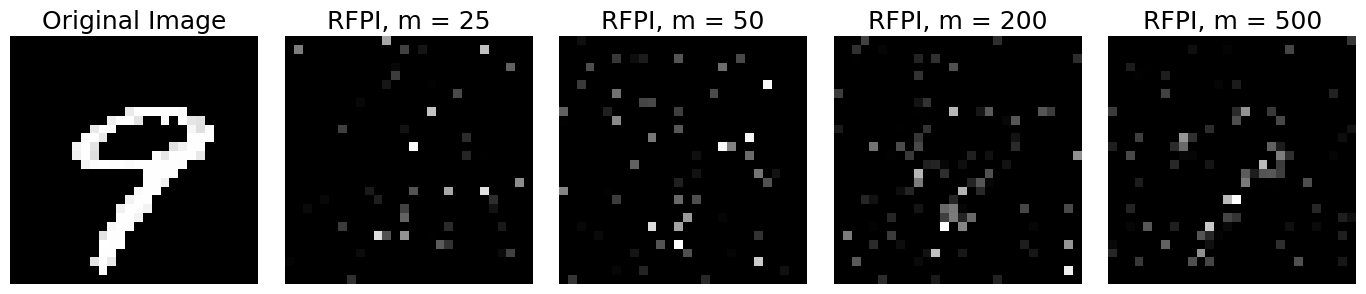

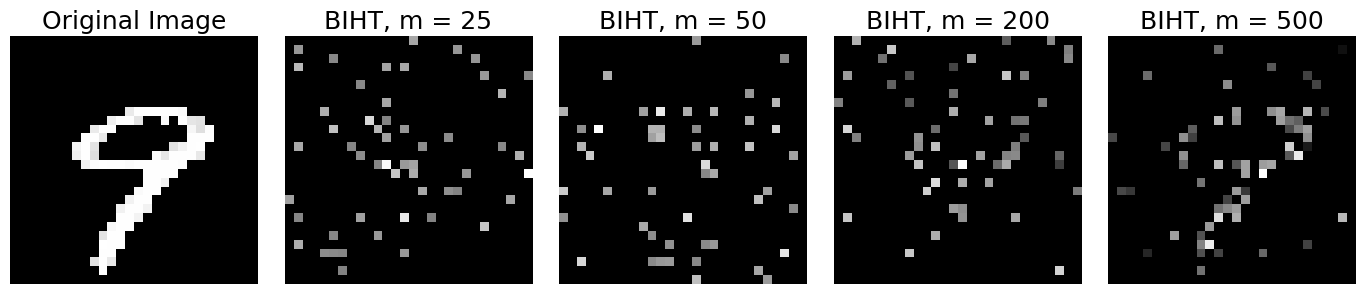

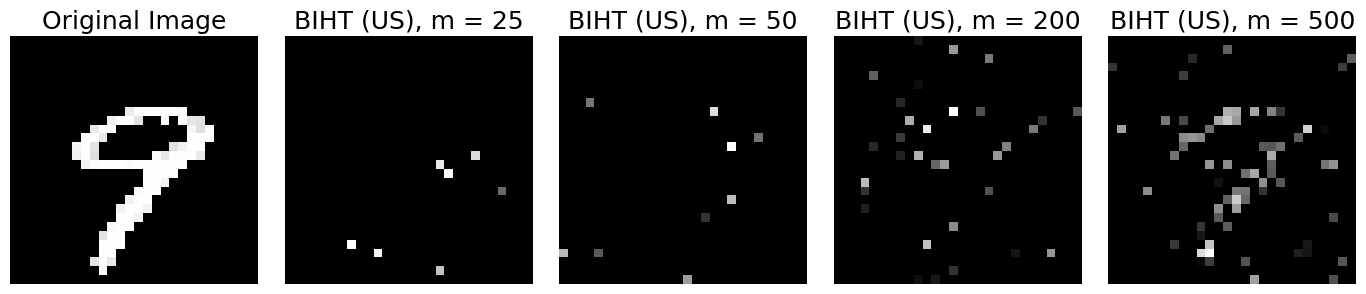

In [607]:
meas_matrix_dims = [25, 50, 200, 500]
num_img = 30
data = import_mnist_data(num_img)
img_idx = 9
sparse_data = sparsify_data(data[img_idx,:].reshape((1,-1)), 220)
np.random.seed(num_img)


gen_algo_plots("RFPI", "rfpi", sparse_data, meas_matrix_dims, 1e-4, 1, 0, False, 1e-4, 1000)
gen_algo_plots("BIHT", "biht", sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 0, 1000)
gen_algo_plots("BIHT (US)", "biht", sparse_data, meas_matrix_dims, 1e-5, 0.1, 10, False, 0, 1000)

**When does reconstruction succeed?** Sparsity levels, matrix coherence

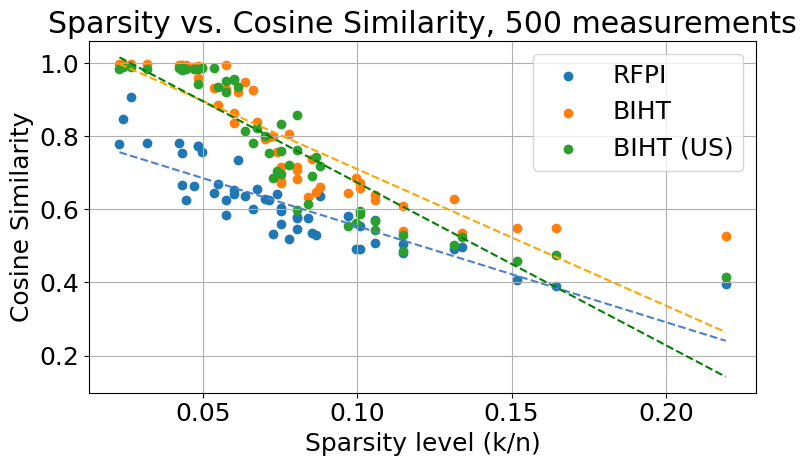

In [558]:
# Analyze how the sparsity level affects the cosine similarity
num_img = 50
m = 500
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 220)
cosine_sim_biht, sparsities_biht = plot_sparsities("biht", sparse_data, num_img, m, 1e-5, 0.1, 80, True, 0, 1000)
cosine_sim_biht_us, sparsities_biht_us = plot_sparsities("biht", sparse_data, num_img, m, 1e-5, 0.1, 10, False, 0, 1000)
cosine_sim_rfpi, sparsities_rfpi = plot_sparsities("rfpi", sparse_data, num_img, m, 1e-4, 1, 0, False, 1e-4, 1000)

# Set the randomization seed for consistency
np.random.seed(num_img)

plt.figure(figsize=(8, 5))
plt.scatter(sparsities_rfpi, cosine_sim_rfpi)
plt.scatter(sparsities_biht, cosine_sim_biht)
plt.scatter(sparsities_biht_us, cosine_sim_biht_us)
# Fit trendlines (1st-degree polynomial for linear fit)
rfpi_fit = np.polyfit(sparsities_rfpi, cosine_sim_rfpi, 1)
biht_fit = np.polyfit(sparsities_biht, cosine_sim_biht, 1)
biht_fit_us = np.polyfit(sparsities_biht_us, cosine_sim_biht_us, 1)
x_rfpi = np.linspace(min(sparsities_rfpi), max(sparsities_rfpi), 100)
x_biht = np.linspace(min(sparsities_biht), max(sparsities_biht), 100)
x_biht_us = np.linspace(min(sparsities_biht_us), max(sparsities_biht), 100)
y_rfpi = np.polyval(rfpi_fit, x_rfpi)
y_biht = np.polyval(biht_fit, x_biht)
y_biht_us = np.polyval(biht_fit_us, x_biht)
# Plot trendlines
plt.plot(x_rfpi, y_rfpi, color=[0.3,0.5,0.8], linestyle="--")
plt.plot(x_biht, y_biht, color="orange", linestyle="--")
plt.plot(x_biht_us, y_biht_us, color="green", linestyle="--")
plt.xlabel("Sparsity level (k/n)")
plt.ylabel("Cosine Similarity")
plt.title(f"Sparsity vs. Cosine Similarity, {m} measurements")
plt.legend(["RFPI", "BIHT", "BIHT (US)"])
plt.grid(True)
plt.tight_layout()
plt.show()
